In [1]:
using GittinsIndices
using Distributions
using Plots
using ProgressMeter
using Latexify
using BenchmarkTools

[ Info: Precompiling GittinsIndices [528e2044-b1ef-47f1-a8f4-693ac85d91f9]


In [2]:
function get_gittins_action(gittins_priors, gamma)
    gittins_indices = [
        calculate_bernoulli_gittins(
            alpha = alpha, 
            beta = beta, 
            gamma = gamma,
        ) for (alpha, beta) in gittins_priors
    ]
    gittins_action = argmax(gittins_indices)
    return gittins_action
end

function get_thompson_action(thompson_priors)
    thompson_sampling_probs = [
        alpha / (alpha + beta) 
        for (alpha, beta) in thompson_priors
    ]
    thompson_sampling_probs ./= sum(thompson_sampling_probs)
    thompson_action = rand(Categorical(thompson_sampling_probs))
    return thompson_action
end

function get_ucb_action(ucb_arm_rewards, ucb_arm_counts, c = 1.0)
    total_count = sum(ucb_arm_counts)
    ucb_bounds = ucb_arm_rewards ./ ucb_arm_counts .+ c .* sqrt.(total_count ./ ucb_arm_counts)
    ucb_action = argmax(ucb_bounds)
    return ucb_action
end

get_ucb_action (generic function with 2 methods)

In [11]:
function gittins_vs(;num_arms, num_pulls)
    arms = [Bernoulli(rand(Float64)) for _ in 1:num_arms]
    best_arm_p = maximum([arm.p for arm in arms])
    optimal_rewards = collect(1:num_pulls) .* best_arm_p
    
    gittins_priors = [[1, 1] for _ in 1:num_arms]
    gittins_rewards = []
    
    thompson_priors = [[1, 1] for _ in 1:num_arms]
    thompson_rewards = []
    
    ucb_arm_rewards = [0.0 for _ in 1:num_arms]
    ucb_arm_counts = [1 for _ in 1:num_arms]
    ucb_rewards = []
    
    @showprogress for pull in 1:num_pulls
        # gittins indices
        gamma = 1 - 1 / pull # increasing gamma as in Optimistic Gittins Indices paper
        gittins_action = get_gittins_action(gittins_priors, gamma)
        gittins_reward = rand(arms[gittins_action])
        push!(gittins_rewards, gittins_reward)
        gittins_priors[gittins_action][gittins_reward ? 1 : 2] += 1
        
        # thompson sampling
        thompson_action = get_thompson_action(thompson_priors)
        thompson_reward = rand(arms[thompson_action])
        push!(thompson_rewards, thompson_reward)
        thompson_priors[thompson_action][thompson_reward ? 1 : 2] += 1
            
        # UCB 
        ucb_action = get_ucb_action(ucb_arm_rewards, ucb_arm_counts)
        ucb_reward = rand(arms[ucb_action])
        push!(ucb_rewards, ucb_reward)
        ucb_arm_counts[ucb_action] += 1
        ucb_arm_rewards[ucb_action] += ucb_reward            
    end
            
    return (
        gittins_regret = optimal_rewards .- cumsum(gittins_rewards), 
        thompson_regret = optimal_rewards .- cumsum(thompson_rewards),
        ucb_regret = optimal_rewards .- cumsum(ucb_rewards),
    )
end

gittins_vs (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:53


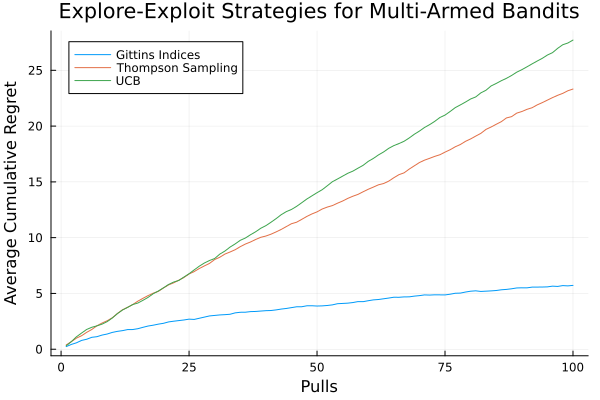

In [26]:
function graph_thompson_gittins()    
    num_simulations = 100
    num_arms = 5
    num_pulls = 100
    
    gittins_regret = zeros(Float64, num_pulls)
    thompson_regret = zeros(Float64, num_pulls)
    ucb_regret = zeros(Float64, num_pulls)

    @showprogress for _ in 1:num_simulations
        result = gittins_vs(
            num_arms = num_arms,
            num_pulls = num_pulls,
        )
        gittins_regret .+= result.gittins_regret
        thompson_regret .+= result.thompson_regret
        ucb_regret .+= result.ucb_regret
    end
    
    gittins_regret = gittins_regret ./ num_simulations
    thompson_regret = thompson_regret ./ num_simulations
    ucb_regret = ucb_regret ./num_simulations
    
    plot(
        1:num_pulls, 
        [
            gittins_regret,
            thompson_regret,
            ucb_regret
        ], 
        title="Explore-Exploit Strategies for Multi-Armed Bandits", 
        label=["Gittins Indices" "Thompson Sampling" "UCB"],
        xlabel="Pulls",
        ylabel="Average Cumulative Regret",
    )

end

graph_thompson_gittins()

In [43]:
function gi_table()
    gis = calculate_bernoulli_gittins(
        alpha = 1, 
        beta = 1, 
        gamma = 0.7,
        pulls = 10,
    )
    rows, cols = size(gis)
    for i in 1:rows
        for j in 1:cols
            if !ismissing(gis[i, j])
                gis[i, j] = round(gis[i, j], digits=3)
            end
        end
    end
    return gis
end

gis = gi_table()
latexify(gis)

"\\begin{equation}\n\\left[\n\\begin{array}{cccccccccc}\n0.605 & 0.735 & 0.798 & 0.836 & 0.861 & 0.879 & 0.893 & 0.904 & 0.913 & 0.92 \\\\\n0.412 & 0.565 & 0.652 & 0.708 & 0.749 & 0.779 & 0.803 & 0.821 & 0.837 & \\textrm{NA} \\\\\n0.307 & 0.455 & 0.547 & 0.612 & 0.66 & 0.697 & 0.727 &" ⋯ 616 bytes ⋯ " \\textrm{NA} & \\textrm{NA} & \\textrm{NA} & \\textrm{NA} & \\textrm{NA} & \\textrm{NA} & \\textrm{NA} \\\\\n0.105 & \\textrm{NA} & \\textrm{NA} & \\textrm{NA} & \\textrm{NA} & \\textrm{NA} & \\textrm{NA} & \\textrm{NA} & \\textrm{NA} & \\textrm{NA} \\\\\n\\end{array}\n\\right]\n\\end{equation}\n"

In [48]:
@btime calculate_bernoulli_gittins(
    alpha = 1, 
    beta = 1, 
    gamma = 0.7,
)

  1.371 ms (7340 allocations: 10.42 MiB)


0.6047903207632213

In [49]:
@btime calculate_bernoulli_gittins(
    alpha = 1, 
    beta = 1, 
    gamma = 0.7,
    pulls = 10,
)

  132.071 ms (488328 allocations: 696.30 MiB)


10×10 Matrix{Union{Missing, Float64}}:
 0.604567  0.735477  0.79825   0.835684  …  0.904199  0.912806  0.919959
 0.41206   0.565241  0.652164  0.708439     0.821249  0.836628   missing
 0.307349  0.45468   0.546865  0.612189     0.750833   missing   missing
 0.243185  0.379087  0.469857  0.536853      missing   missing   missing
 0.200337  0.323577  0.41186   0.477774      missing   missing   missing
 0.170122  0.281916  0.365415  0.430812  …   missing   missing   missing
 0.147315  0.249581  0.327859  0.390998      missing   missing   missing
 0.129692  0.223823  0.298193   missing      missing   missing   missing
 0.115923  0.202328   missing   missing      missing   missing   missing
 0.104534   missing   missing   missing      missing   missing   missing

In [50]:
@btime calculate_bernoulli_gittins(
    alpha = 1, 
    beta = 1, 
    gamma = 0.7,
    pulls = 50,
)

  2.530 s (8316949 allocations: 11.58 GiB)


50×50 Matrix{Union{Missing, Float64}}:
 0.604567   0.735477   0.79825    0.835684   …  0.980255  0.980564  0.980867
 0.41206    0.565241   0.652164   0.708439      0.961444  0.962341   missing
 0.307349   0.45468    0.546865   0.612189      0.943414   missing   missing
 0.243185   0.379087   0.469857   0.536853       missing   missing   missing
 0.200337   0.323577   0.41186    0.477774       missing   missing   missing
 0.170122   0.281916   0.365415   0.430812   …   missing   missing   missing
 0.147315   0.249581   0.327859   0.390998       missing   missing   missing
 0.129692   0.223823   0.298193   0.358009       missing   missing   missing
 0.115923   0.202328   0.272354   0.330238       missing   missing   missing
 0.104534   0.185137   0.250891   0.306372       missing   missing   missing
 0.095116   0.170016   0.232252   0.285236   …   missing   missing   missing
 0.0872115  0.157402   0.216171   0.26716        missing   missing   missing
 0.0807058  0.146317   0.202254   0.2

In [51]:
@btime calculate_bernoulli_gittins(
    alpha = 1, 
    beta = 1, 
    gamma = 0.7,
    pulls = 100,
)

  8.073 s (27258966 allocations: 37.92 GiB)


100×100 Matrix{Union{Missing, Float64}}:
 0.604567   0.735477   0.79825    0.835684   …  0.998015  0.998511  0.998883
 0.41206    0.565241   0.652164   0.708439      0.9857    0.9861     missing
 0.307349   0.45468    0.546865   0.612189      0.972359   missing   missing
 0.243185   0.379087   0.469857   0.536853       missing   missing   missing
 0.200337   0.323577   0.41186    0.477774       missing   missing   missing
 0.170122   0.281916   0.365415   0.430812   …   missing   missing   missing
 0.147315   0.249581   0.327859   0.390998       missing   missing   missing
 0.129692   0.223823   0.298193   0.358009       missing   missing   missing
 0.115923   0.202328   0.272354   0.330238       missing   missing   missing
 0.104534   0.185137   0.250891   0.306372       missing   missing   missing
 0.095116   0.170016   0.232252   0.285236   …   missing   missing   missing
 0.0872115  0.157402   0.216171   0.26716        missing   missing   missing
 0.0807058  0.146317   0.202254   0

In [64]:
gi = calculate_gaussian_gittins(mu=0, tau=1, n=10, gamma=0.7, tol=1e-3, N=20, xi=3, delta=0.1)
gi2 = calculate_gaussian_gittins(mu=0, tau=1, n=10, gamma=0.7, tol=1e-3, N=100, xi=3, delta=0.02)
println(gi, " ", gi2)

0.05739517547346165 0.056567644622145
